# PROJECT: Course Optimization for Data Science
## Optimization strategies for Support Vector Machines (SVM)

Authors: Alexandre Gramfort, Stéphane Gaiffas

If you have questions or if something is not clear in the text below please contact us
by email.

## Aim:

- derive the duals for SVMs with and without intercept
- implement an SVM using a blackbox convex toolbox (cvxopt in Python)
- implement your own solvers for the without intercept case: Proximal gradient, Coordinate Descent, Newton, Quasi-Newton
- Present a clear benchmark of the different strategies on small and medium scale datasets


## VERY IMPORTANT

This work must be done by pairs of students.
Each student must send their work before the 3rd of January at 23:59, using the moodle platform.
This means that **each student in the pair sends the same file**

On the moodle, in the "Optimization for Data Science" course, you have a "devoir" section called "Project".
This is where you submit your jupyter notebook file.

The name of the file must be constructed as in the next cell

### Gentle reminder: no evaluation if you don't respect this EXACTLY

#### How to construct the name of your file

In [1]:
# Change here using YOUR first and last names
fn1 = "come"
ln1 = "arvis"
fn2 = "guillaume"
ln2 = "ligner"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["project", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

project_arvis_come_and_ligner_guillaume.ipynb


Some imports

In [2]:
%matplotlib inline
import numpy as np
from scipy import linalg
import time
import matplotlib.pyplot as plt

## Important:

For Part 0 to Part 2 of the project you will need a working install of `cvxopt`.
You may struggle a bit to set it up.
The simplest way of getting it is by typing 

`pip install cvxopt`

if you have `pip` installed on your laptop.
If you **struggle too much please
contact us**.

## Part 0: SVM Classification with linear kernel

Let us consider the problem of binary classification from $n$ observations
$x_i \in \mathbb{R}^{d}$,
$1 \leq i \leq n$. We aim to learn a function:
$$f: x \in \mathbb{R}^{d}\mapsto y\in\{-1,+1\}$$
from the $n$ annotated training samples $(x_{i},y_{i})$ supposed i.i.d. from an unknown probability distribution on $\mathbb{R}^d \times \{-1,+1\}$. Once this function is learnt, it will be possible to use it to predict the label $y$ associated to a new sample $x$.

Margin and linear separating hyperplane:

<img src="separateur.png">

In the linear case, one looks for an affine function of $x$ of the form 
$f(x) = \mathrm{sign}(w^{\top} x)$ or $f(x)=\mathrm{sign}(w^{\top}x + b)$
with $w \in \mathbb{R}^d$ and $b \in \mathbb{R}$. The first case is referred
to as the **without intercept** case. Indeed the coefficient $b$ is known
as the intercept or bias term.

We will start by considering the case with intercept.

To learn $f$, we use the $n$ annotated samples and one looks for a hyperplane $P(w,b)$
such that the smallest distance to positive and negative samples
is the largest. This can be written as:
$$
 \max_{w,b} \min_{i=1:n} y_i \delta(x_{i},P(w,b)) \quad
 \text{where}\quad \delta(x_{i},w,b) = \frac{w^{\top}x_{i}+b}{\sqrt{w^{\top}w}} \enspace,
$$
since the signed distance from a sample $x_{i}$ to the hyperplane $P(w,b)$ is given by
$
\delta(x_{i},w,b)
$.
The principle described above is the maximisation of the *margin*.

One can notice that if the minimum of a set of values is larger than $m$ than all values of the set are larger than $m$. This leads to the following problem formulation:
$$
 \left\{
 \begin{array}{cll}
 \max_{(w,b)} \quad m \\
 \text{s.t.} \;\; &\forall i &y_i\dfrac{w^{\top}x_{i}+b}{\sqrt{w^{\top}w}}\geq m
 \end{array}
 \right. \enspace .
$$

The hyperplane separates the space in 2 half spaces, depending if $\delta(x_{i},w,b)$ is positive or negative.

Assuming all samples are linearly separable, convince yourself that the problem can be written as:
$$
(\mathcal{P}):  \left\{
 \begin{array}{cll}
 &\min_{(w,b)} \frac{1}{2}w^{\top}w
 \\
  &y_{i}(w^{\top}x_{i}+b)\geq 1, \quad \forall i\in \{1,\cdots,n\}
 \end{array}
 \right.
$$

### Questions

- Q1: Justify that the problem $(\mathcal{P})$ is convex.

**ANSWER Q1**:

$\frac{1}{2}w^\top w$, as a quadratic form, is convex. 

The condition functions $f_{i}(w,b) = (w^\top x_{i} + b) \quad \forall i\in \{1,\cdots,n\}$ are linear and consequently convex as well since they are twice differentiable and their hessian is positive semi-definite. 

Consequently the problem is convex.

- Q2: By looking at the saddle points of the Lagrangian $\mathcal{L}(w, b, \mu)$, $\mu \in \mathbb{R}_+^n$, show that the dual problem $(\mathcal{D})$ can be written as:
$$
(\mathcal{D}): 
 \left\{
 \begin{array}{lll}
 \min_{\mu} &\frac{1}{2}\mu^{\top}GG^{t}\mu-\mu^{\top}u
 \\
 \mathrm{s.c.}& y^{\top}\mu = 0
 \\
 \mathrm{and}& -\mu \leq  0
 \end{array}
 \right .
$$

with

$$
 G = \begin{bmatrix}y_{1}x_{1}^{\top} \\ \vdots \\ y_{n}x_{n}^{\top}\end{bmatrix}
$$

and $u = (1, \dots, 1) \in \mathbb{R}^n$.

We will **assume here qualification of the contraints**.

Remark: The problem $(\mathcal{D})$ is a *quadratic program* (QP) for which their exist off-the-shelf techniques. See below.

**ANSWER Q2**:

The condition functions can be written as : 
$$f_{i}(w,b) = - y_i(w^\top x_i + b) + 1$$

Thus the Lagrangian can be written as : 

$\mathcal{L}(w, b, \mu) = \frac{1}{2}w^\top w + \sum_{i=1}^n -\mu_i [y_i(w^\top x_i + b) + 1]$

We here assume qualification of the constraints and according to Karush-Kuhn-Tucker conditions we must have : 
$\mu \geq 0$ $\Leftrightarrow$ $-\mu \leq 0$ so that we can write the dual problem. 

The dual problem can be written as : 

$ (\mathcal{D}): \max_{\mu}\min_{(w,b)} \mathcal{L}(w, b, \mu)$

and $-\mu \leq 0$ as mentioned above. 

Let's find $D(\mu) = \min_{(w,b)} \mathcal{L}(w, b, \mu)$

Since $\mathcal{L}(w, b)$, for a given $\mu$, is convex and differentiable, we find a minimizer (w*,b*) for a given $\mu$ considering $\nabla f(w^{*},b^{*}) = 0$

$$\implies \frac{\partial \mathcal{L}}{\partial w} = 0 = w^{*} - \sum_{i=1}^n \mu_i y_i x_i \Leftrightarrow w^{*} = \sum_{i=1}^n \mu_i y_i x_i = G^\top \mu  \quad$$
$$and, \frac{\partial \mathcal{L}}{\partial b} = 0 = - \sum_{i=1}^n \mu_i y_i$$

We can therefore rewrite the dual function $D(\mu) = \min_{(w,b)} \mathcal{L}(w, b, \mu)$ as: 

$$D(\mu) = \mathcal{L}(\mu, w^{*}, b^{*})$$
$$= \frac{1}{2} \mu^\top G G^\top \mu - w^{{*}^\top} w^{*} - b \sum_{i=1}^n \mu_i y_i + \sum_{i=1}^n \mu_i$$

We saw just before that $w^{*} = G^\top \mu$ in $\nabla f(w^{*}) = 0$ $\implies$ $w^{{*}\top} w^{*} =   \mu^\top G G^\top \mu$

Also we saw that at $b^{*}$ we have $\sum_{i=1}^n \mu_i y_i = y^\top \mu = 0$ and $\mu \geq 0$ (inital Karush-Kuhn-Tucker condition used to write the dual problem)

$\implies$ Dual function:
$$D(\mu) = -\frac{1}{2} \mu^\top G G^\top \mu + \mu^\top u$$

$\implies$ Dual problem: 

$$ (\mathcal{D}): \begin{cases}\max_\mu D(\mu) = -\frac{1}{2} \mu^\top G G^\top \mu + \mu^\top u \\ \text{s.t. } -\mu \leq 0 \\ y^\top \mu = 0 \end{cases}$$

Which can be written with its equivalent:
$$ (\mathcal{D}): \begin{cases}\min_\mu -D(\mu) = \frac{1}{2} \mu^\top G G^\top \mu - \mu^\top u \\ \text{s.t. } \mu \leq 0 \\ y^\top \mu = 0 \end{cases}$$

- Q3: Justify that given the estimated $\mu$, the prediction function for a new sample $x$ is given by:

$$
y = \mathrm{sign}(\sum_{i=1}^{n} \mu_i y_i x_i^\top x + b) \enspace .
$$

The vector $w$ is therefore equal to $\sum_{i=1}^{n} \mu_i y_i x_i$

**ANSWER Q3**:

We want to find $w^{*}$ that minimizes the primal problem. 

At saddle point $(w^{*}, b^{*}, \mu ^{*})$ of the Lagrangian we have :

$$\frac{\partial \mathcal{L}}{\partial w} = w^{*} - \sum_{i=1}^n \mu_i y_i x_i = 0
\implies w^{*} = \sum_{i=1}^n \mu_i y_i x_i$$ 

And the initial prediction function being :
$$y = \mathrm{sign}(w^{{*}^\top} x + b)$$

With an approximation of $\mu$ and using the above expression of $w^{*}$ we have :
$$y = \mathrm{sign}(\sum_{i=1}^{n} \mu_i y_i x_i^\top x + b)$$

## Part 1: Implementation of solver with intercept using cvxopt

The file svm_project_utils.py contains the code to generate some toy data and plot them

In [3]:
from svm_project_utils import plot_dataset, datasets

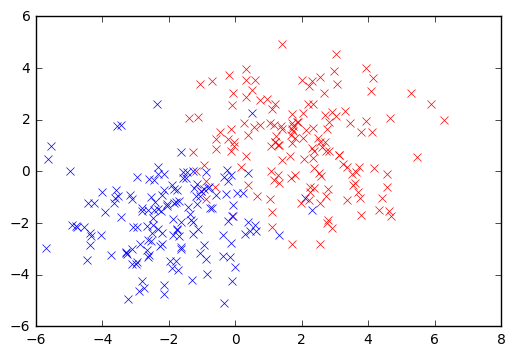

In [4]:
X, y = datasets(name='gaussian', n_points=300)
plot_dataset(X, y)

- The following function qp allows to solve a quadratic problem of the form:

$$
\left\{
  \begin{array}{cll}
  &\min_{(x)} \frac{1}{2}x^{\top} H x - e^\top x
  \\
   & \textrm{s.c.}\; A^\top x = b, 0 \leq x \leq C.
  \end{array}
  \right.
$$

In [5]:
import cvxopt


def qp(H, e, A, b, C=np.inf, l=1e-8, verbose=True):
    # Gram matrix
    n = H.shape[0]
    H = cvxopt.matrix(H)
    A = cvxopt.matrix(y, (1, n))
    e = cvxopt.matrix(-e)
    b = cvxopt.matrix(0.0)
    if C == np.inf:
        G = cvxopt.matrix(np.diag(np.ones(n) * -1))
        h = cvxopt.matrix(np.zeros(n))
    else:
        G = cvxopt.matrix(np.concatenate([np.diag(np.ones(n) * -1),
                                         np.diag(np.ones(n))], axis=0))
        h = cvxopt.matrix(np.concatenate([np.zeros(n), C * np.ones(n)]))

    # Solve QP problem
    cvxopt.solvers.options['show_progress'] = verbose
    solution = cvxopt.solvers.qp(H, e, G, h, A, b)
 
    # Lagrange multipliers
    mu = np.ravel(solution['x'])
    return mu

Definition of the linear kernel:

In [6]:
def kernel(X1, X2):
    n1 = X1.shape[0]
    n2 = X2.shape[0]
    K = np.empty((n1, n2))
    for i in range(n1):
        for j in range(n2):
            K[i, j] = np.dot(X1[i], X2[j])
    return K

### Questions

- Q4: Modify the following cell to solve the SVM dual problem:

Number of support vectors: 2


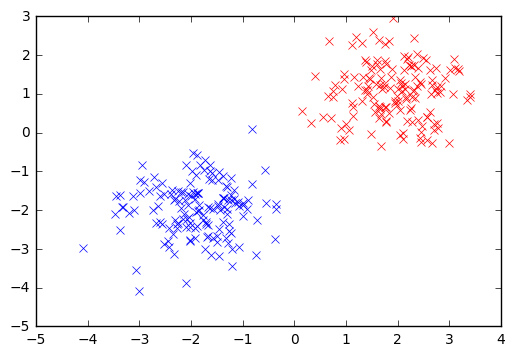

In [7]:
X, y = datasets(name='gaussian', n_points=300, sigma=0.7)
plot_dataset(X, y)

def svm_solver(K, y, C=np.inf):
    y = y.reshape((-1, 1))
    H = y.dot(y.T) * K
    e = np.ones((H.shape[1], 1)) # Since e is mu in our case, a vector of size G.T.shape[1] or H.shape[1] 
    A = y
    b = 0 # Since A.T.dot(x) = 0
    mu = qp(H, e, A, b, C, l=1e-8, verbose=False)
    idx_support = np.where(np.abs(mu) > 1e-5)[0]
    mu_support = mu[idx_support]
    return mu_support, idx_support

K = kernel(X, X)

mu_support, idx_support = svm_solver(K, y)
print("Number of support vectors: %s" % idx_support.size)

- Q5: Compute w from mu and b

In [8]:
w = (X[idx_support].T * y[idx_support]).dot(mu_support)
print(w)

[ 1.6744786   0.78521948]


- Q6: Using complementary slackness, explain how to obtain $b$ from $\mu$.

HINT: Use the fact that for all support vectors for which $\mu_i$ is non-zero one has $y_{i}(w^{t}x_{i}+b) = 1$.

**ANSWER Q6**:

We choose an index $i$ for which $\mu_i$ is non-zero. Thus the KKT tells us that $y_{i}(w^\top x_{i}+b) = 1$

Therefore : 
$$b = 1 - w^\top x_{i}$$

We use the expression, of $w^{*}$ the minmizer of the primal problem, found is question 3 :
$$w^{*} = \sum_{k=1}^n \mu_k y_k x_k$$

Replacing $w$ by the previous expression, we obtain the following formula to compute $b$ : 
$$b = y_i - \sum_{j=1}^n \mu_j y_j x_j^\top x_i$$

In [9]:
def compute_b(K, y, mu_support, idx_support):
    y_support = y[idx_support]
    K_support = K[idx_support][:, idx_support]
    indice_chosen = np.where(mu_support != 0)[0][0] # First index where mu_i is non-zero
    b = y_support[indice_chosen] -  np.sum(mu_support * y_support * K_support[indice_chosen])
    return b

b = compute_b(K, y, mu_support, idx_support)
print(b)

0.305291100448


- Q7: Verify that the constraints of the primal problem are satistified up to an acceptable numerical precision. You should verify that for all $i$ we have:

$$
y_{i}(w^{\top}x_{i}+b) \geq 1 - \epsilon
$$

using for example $\epsilon = 1e-5$.

In [10]:
epsilon = 1e-5
constraints_ok = ((y * w.dot(X.T) + y * b) >= 1 - epsilon).all()

print("Contraints of the primal problem satisfied:", constraints_ok)

Contraints of the primal problem satisfied: True


Check your code by running the following cell:

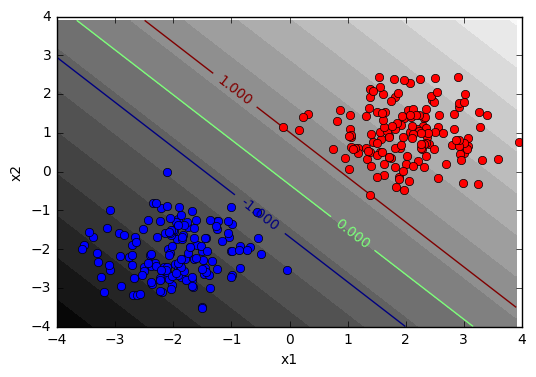

In [11]:
X, y = datasets(name='gaussian', n_points=300, sigma=0.7)

K = kernel(X, X)
mu_support, idx_support = svm_solver(K, y)
b = compute_b(K, y, mu_support, idx_support)

def plot_classif(X, y, mu_support, idx_support, b, kernel=kernel):
    # Calcul de la fonction de décision sur une grille
    X1, X2 = np.mgrid[-4:4:0.1, -4:4:0.1]
    na, nb = X1.shape
    X_test = np.c_[np.reshape(X1, (na * nb, 1)),
                   np.reshape(X2, (na * nb, 1))]

    # Calcul des produits scalaires
    X_support = X[idx_support]
    G = kernel(X_test, X_support)
    # Calcul de la fonction de décision
    decision = G.dot(mu_support * y[idx_support]) + b

    # Calcul du label prédit
    y_pred = np.sign(decision)

    # Affichage des lignes de niveau de la fonction de decision
    plt.contourf(X1, X2, np.reshape(decision, (na, nb)), 20, cmap=plt.cm.gray)
    cs = plt.contour(X1, X2, np.reshape(decision, (na,nb)), [-1, 0, 1], color='g', linewidth=2)
    plt.clabel(cs, inline=1)
    plt.plot(X[y == 1,0], X[y == 1, 1], 'or', linewidth=2)
    plt.plot(X[y == -1,0], X[y == -1, 1], 'ob', linewidth=2)
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.xlim([-4, 4])
    plt.ylim([-4, 4])

plot_classif(X, y, mu_support, idx_support, b)

We will now change the value of $\sigma$ such that the problem is not linearily separable anymore.

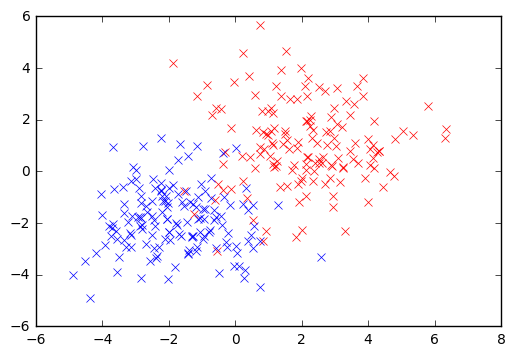

In [12]:
X, y = datasets(name='gaussian', n_points=300, sigma=1.5)
plot_dataset(X, y)

In [13]:
K = kernel(X, X)
mu_support, idx_support = svm_solver(K, y)
b = compute_b(K, y, mu_support, idx_support)
w = np.sum((mu_support * y[idx_support])[: , None] * X[idx_support], axis=0)

Terminated (singular KKT matrix).


- Q8: Check that contraints of the problem are now violated.

In [14]:
epsilon = 1e-5
constraints_ok = ((y * w.dot(X.T) + y * b) >= 1 - epsilon).all()

print("Contraints of the primal problem satisfied:", constraints_ok)

Contraints of the primal problem satisfied: False


## Part 1: Non separable case with cvxopt

In practice it is very likely that the classes are not linearly separable.

A very natural idea is to relax the constraints $y_{i}(w^\top x_i + c) \geq 1$.
To do this, so called soft-margin SVM have been introduced using
so called slack variables: $\xi_{i}\geq 0$. The problem becomes:

$$
 y_{i}(w^\top x_i + b) \geq 1 - \xi_i, \; \xi_i \geq 0 \enspace .
$$

Note that if $\xi_i > 1$, the sample $x_{i}$ will be misclassified. To prevent
this case to be too frequent, an idea is to minimize the sum of the $\xi_{i}$.
This leads to the following problem:

$$
(P_{s}):  \left\{
 \begin{array}{ll}
 \min_{(w,b,\xi)} & \frac{1}{2}w^{\top}w + C \sum_i \xi_i
 \\
 \mathrm{s.t.} & y_{i}(w^{\top}x_{i}+b) \geq 1 - \xi_i\\
 \mathrm{and} & -\xi_i \leq 0
 \end{array}
 \right.
$$

The constant $C$ controls the regularisation.

### Questions

- Q9: Justify that $(P_{s})$ is a convex problem

**ANSWER Q9 a)**:

The function to minimize over $(w,b,\xi)$ is :

$$\frac{1}{2}w^{\top}w + C \sum_i \xi_i$$

$w^{\top}w$ the quadratic form is convex over those variables and so is $\sum_i \xi_i$ a sum of linear functions. 

Therefore 
$$\frac{1}{2}w^{\top}w + C \sum_i \xi_i$$
is convex and the problem is about minimizing a convex function, which makes it a convex problem.

- Show that a dual problem of $(P_{s})$ reads:

$$
(\mathcal{D}):
\left\{
\begin{array}{lll}
\min_{\mu} &\frac{1}{2}\mu^{\top}GG^{\top}\mu-\mu^{\top}u
\\
\mathrm{s.t.}& y^{\top}\mu = 0
\\
\mathrm{et}& 0 \leq \mu \leq C
\end{array}
\right .
$$

**ANSWER Q9 b)**:

The condition functions can be written as : 

$$f_{i}(w,\xi_i) = -[y_i(w^\top x_i) +\xi_i - 1]$$
$$h_{i}(\xi_i) = -\xi_i$$


Thus the Lagrangian can be written as : 

$$\mathcal{L}(w,b,\xi,\mu,\alpha) =  \frac{1}{2}w^{\top}w + C \sum_i \xi_i + \sum_i -\mu_i[y_i(w^\top x_i + b) +\xi_i - 1] + \sum_i -\alpha_i \xi_i$$


The dual problem can be written as : 

$ (\mathcal{D}): \max_{\mu,\alpha}\min_{(w,b,\xi)} \mathcal{L}(w,b,\xi,\mu,\alpha)$


Let's find $D(\mu,\alpha) = \min_{(w,b,\xi)} \mathcal{L}(w,b,\xi,\mu,\alpha)$

Since $\mathcal{L}(w, b, \xi)$, for a given $(\mu, \alpha)$, is convex and differentiable, we find a minimizer $(w^{*},b^{*}, \xi^{*})$ for a given $(\mu, \alpha)$ considering $\nabla f(w^{*},b^{*},\xi^{*}) = 0$

$$\implies \frac{\partial \mathcal{L}}{\partial w} = 0 = w^{*} - \sum_{i=1}^n \mu_i y_i x_i \Leftrightarrow w^{*} = \sum_{i=1}^n \mu_i y_i x_i = G^\top \mu  \quad$$
$$\frac{\partial \mathcal{L}}{\partial b} = 0 = - \sum_{i=1}^n \mu_i y_i = \mu^\top y$$

$$\frac{\partial \mathcal{L}}{\partial \xi}= Cu - \mu - \alpha = 0$$

We can therefore rewrite the dual function $D(\mu,\alpha) = \min_{(w,b,\xi)} \mathcal{L}(w,b,\xi,\mu,\alpha)$ as: 

$$D(\mu,\alpha) = \mathcal{L}(w^{*},b^{*},\xi^{*},\mu,\alpha)$$

$$= \frac{1}{2}\mu^\top G G^\top \mu + \xi^\top Cu - w^{{*}^\top} w^{*} -  \mu^\top y b + \mu^\top u - \xi^\top \mu  - \xi^\top \alpha$$

From the previous steps we know that : 
$$w^{*} = G^\top \mu$$
$$\mu^\top y = 0$$
$$Cu = \mu + \alpha$$

Therefore The dual function can be written :
$$D(\mu,\alpha) = \mathcal{L}(w^{*},b^{*},\xi^{*},\mu,\alpha)$$
$$= -\frac{1}{2}\mu^\top G G^\top \mu  + \mu^\top u$$


The problem is about minimizing a convex function under convex inequality functions. Therefore KKT apply here and : 
$$\mu \geq 0$$
$$\alpha \geq 0$$
Since
$$Cu = \alpha + \mu$$
We have
$$\mu_i = C - \alpha_i \quad {1 \leq i \leq n}$$ 
$$\implies 0  \leq \mu_i \leq C \quad {1 \leq i \leq n}$$
$$\implies 0  \leq \mu \leq C$$

Dual function:
$$D(\mu) = -\frac{1}{2}\mu^\top G G^\top \mu  + \mu^\top u$$

Dual problem: 

$$ (\mathcal{D}): \begin{cases}\max_{(\mu)} D(\mu) = -\frac{1}{2}\mu^\top G G^\top \mu  + \mu^\top u \\ \text{s.t. } 0  \leq \mu \leq C \\ y^\top \mu = 0 \end{cases}$$

Which can be written equivalently:
$$ (\mathcal{D}): \begin{cases}\min,_{(\mu)} -D(\mu) = \frac{1}{2}\mu^\top G G^\top \mu  - \mu^\top u \\ \text{s.t. } 0  \leq \mu \leq C \\ y^\top \mu = 0 \end{cases}$$

- Q10: Modify your code from Q4 to handle the non-separable case.

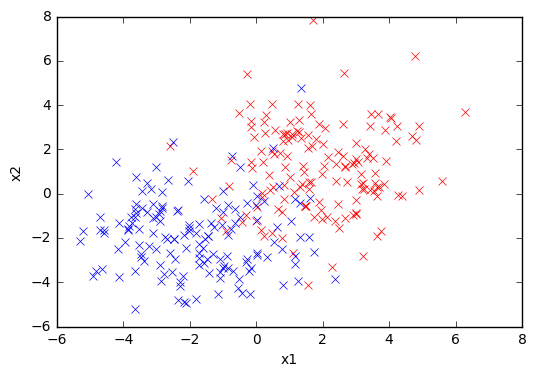

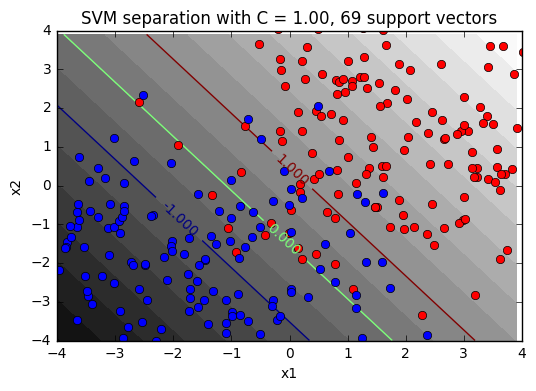

In [30]:
X, y = datasets(name='gaussian', n_points=300, sigma=1.7)
plt.figure(1)
plt.xlabel('x1')
plt.ylabel('x2')
plot_dataset(X, y)

K = kernel(X, X)
C = 1
mu_support, idx_support = svm_solver(K, y, C=C)
b = compute_b(K, y, mu_support, idx_support)

plt.figure(2)
plt.title('SVM separation with C = %.2f, %d support vectors' % (C, idx_support.size))
plot_classif(X, y, mu_support, idx_support, b)

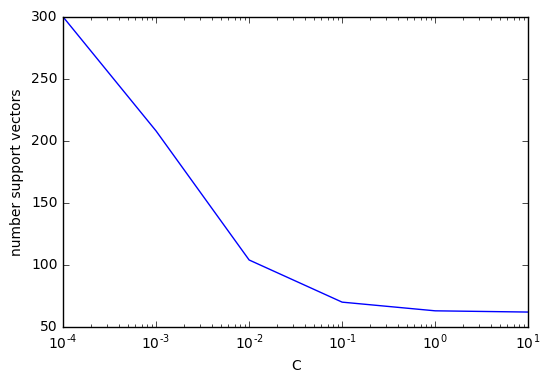

In [16]:
C_array = [0.0001, 0.001, 0.01, 0.1, 1, 10]
sv_array = []
for C in C_array:
    mu_support, idx_support = svm_solver(K, y, C=C)
    b = compute_b(K, y, mu_support, idx_support)
    sv_array.append(idx_support.size)

plt.plot(C_array, sv_array)
plt.xlabel('C')
plt.ylabel('number support vectors')
plt.xscale('log')

- Q11: What is the influence of C on the number of support vectors? Justify this from an optimization stand point.

**ANSWER Q11**:

For a non-separable problem, we have to add some penalization by setting C to a non infinite value.
As we can see above, the number of support vectors decreases as C increases (from $300$ for $C=10^{-4}$ to $50$ for $C=10$). <br>
In other terms, a strong penalization (C is low) allows us to have a high number of support vectors as the marge become larger, but we risk to fail many predictions. On the contrary, a small penalization gives us fiewer support vectors with a marge reduced and a risk to overfit our results.

## Part 2: non-linear case with kernels

Another scenario is when the boundary between classes is not linear.

To cope with this the idea is to use kernels.

- Q12: Denoting by $K(x_i, x_j)$ the dot product between samples show that dual problem and the decision function f(x) can be reformulated just using calls to $K$

**ANSWER Q12**:

Decision function is written :
$$y = \mathrm{sign}(w^{{*}^\top} x + b)$$

From Q9 we know that : 
$$w^{*} = \sum_{i=1}^n \mu_i y_i x_i$$

Therefore the decision function can be equivalently written :
$$y = \mathrm{sign}(\sum_{i=1}^n y_i \mu_i x_i^\top x + b)$$
$$y = \mathrm{sign}(\sum_{i=1}^n y_i \mu_i K(x, x_i) + b)$$

We will use the clowns dataset to evaluate this:

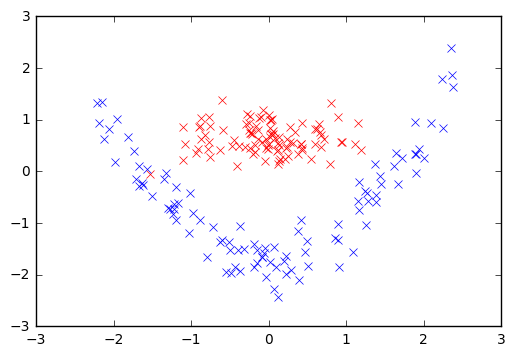

In [17]:
X, y = datasets(name='clowns', n_points=200, sigma=0.7)

plot_dataset(X, y)

- Q13: Update your kernel function so it computes the Gaussian kernel:

$$
    K(x_i, x_j) = \exp(-\gamma \| x_i - x_j \|)
$$

where $\gamma > 0$ is the kernel bandwidth.

In [18]:
from scipy import linalg

def rbf_kernel(X1, X2):
    n1 = X1.shape[0]
    n2 = X2.shape[0]
    K = np.empty((n1, n2))
    gamma = 3.
    for i in range(n1):
        for j in range(n2):
            K[i, j] = np.exp(-gamma * np.linalg.norm(X1[i] - X2[j])) # By definition of the Gaussian kernel
    return K

Using the change above the follwing code should allow you to nicely separate the red from the blue dots

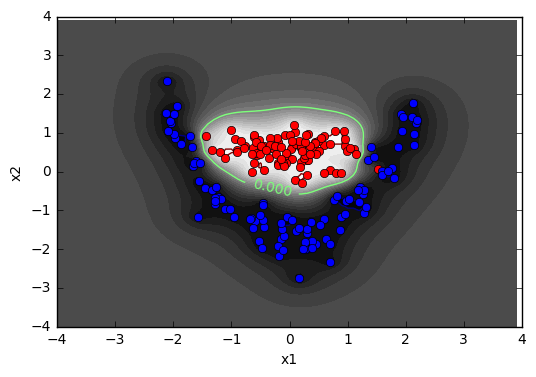

In [19]:
X, y = datasets(name='clowns', n_points=200, sigma=0.7)

K = rbf_kernel(X, X)
mu_support, idx_support = svm_solver(K, y, C=1.)
b = compute_b(K, y, mu_support, idx_support)

plot_classif(X, y, mu_support, idx_support, b, kernel=rbf_kernel)

## Part 3: Linear SVM without intercept

The problem of the formuation of SVMs with the intercept term $b$ is that
it leads to an annoying constraint in the dual, namely the $y^{t}\mu = 0$.

We will now see what we can do about it.

Let's consider the problem

$$
(P'_{s}):  \left\{
 \begin{array}{ll}
 \min_{(w,\xi)} & \frac{1}{2}w^{\top}w + C \sum_i \xi_i
 \\
 \mathrm{s.t.} & y_{i}(w^{\top}x_{i}) \geq 1 - \xi_i\\
 \mathrm{and} & -\xi_i \leq 0
 \end{array}
 \right.
$$

- Q14: Show that a dual problem of $(P'_{s})$ is given by:

$$
(\mathcal{D}):
\left\{
\begin{array}{lll}
\min_{\mu} &\frac{1}{2}\mu^{\top}GG^{\top}\mu-\mu^{\top} 1_n
\\
\mathrm{s.t.}& 0 \leq \mu \leq C
\end{array}
\right .
$$

**ANSWER Q14**:

The condition functions can be written as : 

$$f_{i}(w,\xi_i) = -[y_i(w^\top x_i) +\xi_i - 1]$$
$$h_{i}(\xi_i) = -\xi_i$$


Thus the Lagrangian can be written as : 

$$\mathcal{L}(w,\xi,\mu,\alpha) =  \frac{1}{2}w^{\top}w + C \sum_i \xi_i + \sum_i -\mu_i[y_i(w^\top x_i ) +\xi_i - 1] + \sum_i -\alpha_i \xi_i$$


The dual problem can be written as : 

$ (\mathcal{D}): \max_{\mu,\alpha}\min_{(w,\xi)} \mathcal{L}(w,\xi,\mu,\alpha)$


Let's find $D(\mu,\alpha) = \min_{(w,\xi)} \mathcal{L}(w,\xi,\mu,\alpha)$

Since $\mathcal{L}(w, \xi)$, for a given $(\mu, \alpha)$, is convex and differentiable, we find a minimizer $(w^{*}, \xi^{*})$ for a given $(\mu, \alpha)$ considering $\nabla f(w^{*},\xi^{*}) = 0$

$$\implies \frac{\partial \mathcal{L}}{\partial w} = 0 = w^{*} - \sum_{i=1}^n \mu_i y_i x_i \Leftrightarrow w^{*} = \sum_{i=1}^n \mu_i y_i x_i = G^\top \mu  \quad$$
$$\frac{\partial \mathcal{L}}{\partial \xi}= Cu - \mu - \alpha = 0$$

We can therefore rewrite the dual function $D(\mu,\alpha) = \min_{(w,\xi)} \mathcal{L}(w,\xi,\mu,\alpha)$ as: 

$$D(\mu,\alpha) = \mathcal{L}(w^{*},\xi^{*},\mu,\alpha)$$

$$= \frac{1}{2}\mu^\top G G^\top \mu + \xi^\top Cu - w^{{*}^\top} w^{*} + \mu^\top u - \xi^\top \mu  - \xi^\top \alpha$$

From the previous steps we know that : 
$$w^{*} = G^\top \mu$$
$$Cu = \mu + \alpha$$

Therefore The dual function can be written :
$$D(\mu,\alpha) = \mathcal{L}(w^{*},\xi^{*},\mu,\alpha)$$
$$= -\frac{1}{2}\mu^\top G G^\top \mu  + \mu^\top u$$


The problem is about minimizing a convex function under convex inequality functions. Therefore KKT apply here and : 
$$\mu \geq 0$$
$$\alpha \geq 0$$
Since
$$Cu = \alpha + \mu$$
We have
$$\mu_i = C - \alpha_i \quad {1 \leq i \leq n}$$ 
$$\implies 0  \leq \mu_i \leq C \quad {1 \leq i \leq n}$$
$$\implies 0  \leq \mu \leq C$$

Dual function:
$$D(\mu) = -\frac{1}{2}\mu^\top G G^\top \mu  + \mu^\top u$$

Dual problem: 

$$ (\mathcal{D}): \begin{cases}\max_{(\mu)} D(\mu) = -\frac{1}{2}\mu^\top G G^\top \mu  + \mu^\top u \\ \text{s.t. } 0  \leq \mu \leq C\end{cases}$$

Which can be written equivalently:
$$ (\mathcal{D}): \begin{cases}\min,_{(\mu)} -D(\mu) = \frac{1}{2}\mu^\top G G^\top \mu  - \mu^\top u \\ \text{s.t. } 0  \leq \mu \leq C\end{cases}$$


- Q15: Rewrite the dual in the form:


$$
(\mathcal{D}): \min_{\mu} f(\mu) + g(\mu) .
$$

where $f$ is here a smooth function of $\mu$ with L-Liptschitz gradient and $g$ is a non-smooth function that is separable, namely:

$$
g(\mu) = \sum_{i=1}^n g_i(\mu_i)
$$

**ANSWER Q15**:

Given $\frac{1}{2}\mu^{\top}GG^{\top}\mu-\mu^{\top} 1_n$ contrained by $0 \leq \mu_i \leq C$ $\forall i$, we can rewrite it all as $\frac{1}{2}\mu^{\top}GG^{\top}\mu-\mu^{\top} 1_n + \mathbb{I}_{0_n \leq \mu \leq C_n}(\mu)$ with:
$$\mathbb{I}_{0_n \leq \mu \leq C_n}(\mu) =
\begin{cases} 
    0 & \text{if $\forall$ i, $\mu_i$ $\in$ [0,C]} \\ 
    +\infty & \text{if $\exists$ i, $\mu_i$ $\notin$ [0,C]}
\end{cases}
$$
$$= g(\mu)$$
Moreover, we can naturally say that g is non-smooth, and is separable with:
$$
g(\mu) = \sum_{i=1}^n \mathbb{I}_{0 \leq \mu_i \leq C}(\mu_i)
$$

And,
$$
f(\mu) = \frac{1}{2}\mu^{\top}GG^{\top}\mu-\mu^{\top} 1_n
$$

Finally, we can now rewrite our dual form as:
$$
(\mathcal{D}): \min_{\mu} f(\mu) + g(\mu) \Leftrightarrow \min_{\mu} \frac{1}{2}\mu^{\top}GG^{\top}\mu-\mu^{\top} 1_n + \mathbb{I}_{0_n \leq \mu \leq C_n}(\mu)
$$

The dual in the later form can be readily optimized using the methods that you have been studying in this class:

- Proximal gradient method with and without acceleration
- L-BFGS-B
- Coordinate descent

- Q16: Implement:

   - your own version of proximal gradient with and without acceleration
   - your own version of coordinate descent
   - an L-BFGS-B solver using `scipy.optimize.fmin_l_bfgs_b`

Note: We restrict ourselves to linear kernel here.

Note: To handle separating hyperplanes which do not pass throw zero (due to abscence of intercept)
you will add a column of ones to X. You can use something like this:

`X = np.concatenate((X, np.ones((len(X), 1))), axis=1)`

You will test your implementations on the Gaussian blobs and evaluate the performance of your implementations in terms of computation time on problems where the matrix $G G^\top$ can fit in memory.

You should reuse as much as possible the convergence evaluation code that you used during the labs.

For a coordinate descent method to be fast you need to have smart updates. You're expected to
come up with these smart updates in the problem at hand.

BONUS : With a smart implementation of the coordinate descent you should be able to scale the optimization to tens of thousands of samples ie cases where $G G^\top$ does not fit in memory anymore.

**IMPORTANT : This question Q16 is the most important and will constitute half of the final grade on the project !**

In [20]:
from scipy.optimize import fmin_l_bfgs_b
from scipy.optimize import check_grad

In [21]:
n_points = 300
X, y = datasets(name='gaussian', n_points=n_points, sigma=1.2)
X_old = X.copy()
X = np.concatenate((X, np.ones((len(X), 1))), axis=1)

In [22]:
from scipy.linalg import svd

# Linear kernel reused here, only linear separation
def kernel(X1, X2):
    n1 = X1.shape[0]
    n2 = X2.shape[0]
    K = np.empty((n1, n2))
    for i in range(n1):
        for j in range(n2):
            K[i, j] = np.dot(X1[i], X2[j])
    return K

class SVM(object):

    def __init__(self, K, y):
        self.K = K
        self.y = y.reshape((y.shape[0], 1))
        self.GGT = self.y.dot(self.y.T) * K
    
    def grad(self, mu):
        return self.GGT.dot(mu) - 1

    def loss(self, mu):
        return ((0.5 * mu.T).dot(self.GGT).dot(mu) - mu.T.dot(np.ones(mu.size)))

    def lipschitz_constant(self):
        L = np.max(svd(np.multiply(np.multiply(self.y, self.K).T, self.y), full_matrices=False)[1])
        return L
    
    def prox(self, x, C):
        return np.clip(x, 0, C)

In [23]:
K = kernel(X, X)
model = SVM(K, y)
print('Numerical gradient checking: %f' % check_grad(model.loss, model.grad, np.random.randn(300)))

Numerical gradient checking: 0.000067


In [24]:
## We get a precise minimum to compute then distances to minimum

x_init = np.zeros(n_points)
C = 1
bounds = [(0, C)] * n_points
mu_min, f_min, _ = fmin_l_bfgs_b(model.loss, x_init, model.grad, bounds=bounds)

In [25]:
## We will reuse this convergence evaluation method from the previous lab

from scipy.linalg import norm

def inspector(loss_fun, n_iter, verbose=False):
    """A closure called to update metrics after each iteration."""
    objectives = []
    errors = []
    it = [0] # This is a hack to be able to modify 'it' inside the closure.
    def inspector_cl(xk):
        obj = loss_fun(xk) - f_min
        err = norm(xk - mu_min)
        objectives.append(obj)
        errors.append(err)
        if verbose == True:
            if it[0] == 0:
                print(' | '.join([name.center(8) for name in ["it", "obj", "err"]]))
            if it[0] % (n_iter / 5) == 0:
                print(' | '.join([("%d" % it[0]).rjust(8), ("%.2e" % obj).rjust(8), ("%.2e" % err).rjust(8)]))
            it[0] += 1
    inspector_cl.obj = objectives
    inspector_cl.err = errors
    return inspector_cl

ISTA convergence checking:
   it    |   obj    |   err   
       0 | 6.13e+00 | 2.78e+00
      40 | 5.73e+00 | 2.74e+00
      80 | 5.52e+00 | 2.70e+00
     120 | 5.35e+00 | 2.66e+00
     160 | 5.20e+00 | 2.62e+00


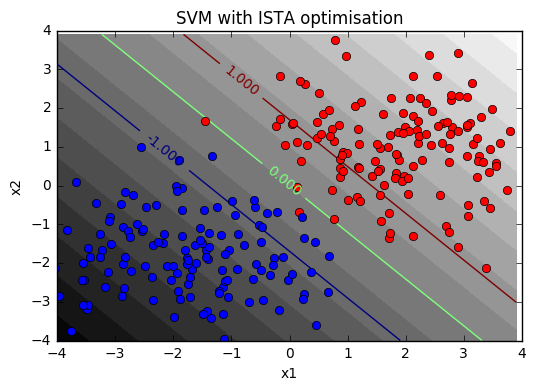

In [26]:
def ista(model, mu_init, C, n_iter=100, step=1., callback=None):
    mu = mu_init.copy()
    
    for _ in range(n_iter):
        
        mu = model.prox(mu - step * model.grad(mu), C)

        if callback: 
            callback(mu)
    
    idx_support = np.where(np.abs(mu) > 1e-5)[0]
    mu_support = mu[idx_support]
    return mu_support, idx_support

step = 1./model.lipschitz_constant()
mu_init = np.zeros(n_points)
n_iter = 200

print('ISTA convergence checking:')
ista_inspector = inspector(model.loss, n_iter=n_iter, verbose=True)
mu_support, idx_support = ista(model, mu_init, C=1., n_iter=n_iter, step=step, callback=ista_inspector)

b = 0
plt.title('SVM with ISTA optimisation')
plot_classif(X_old, y, mu_support, idx_support, b, kernel = kernel)

FISTA convergence checking:
   it    |   obj    |   err   
       0 | 6.13e+00 | 2.78e+00
      40 | 4.72e+00 | 2.48e+00
      80 | 2.85e+00 | 1.80e+00
     120 | 1.01e+00 | 1.05e+00
     160 | 1.57e-01 | 6.53e-01


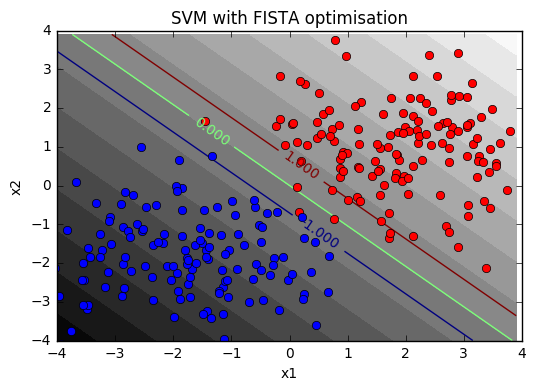

In [27]:
def fista(model, mu_init, C, n_iter=100, step=1., callback=None):
    mu = mu_init.copy()
    y = mu_init.copy()
    t = 1.
    mu_new = mu_init.copy()
    t_new = 1.
    
    for _ in range(n_iter):
        
        mu_new[:] = model.prox(y - step * model.grad(y), C)
        y[:] = mu_new + (t - 1) / t_new * (mu_new - mu)
        t_new = 0.5*(1 + np.sqrt(1 + 4*t*t))
        t = t_new
        mu[:] = mu_new    

        if callback: 
            callback(mu)
    
    idx_support = np.where(np.abs(mu) > 1e-5)[0]
    mu_support = mu[idx_support]
    return mu_support, idx_support

step = 1./model.lipschitz_constant()
mu_init = np.zeros(n_points)
n_iter = 200

print('FISTA convergence checking:')
fista_inspector = inspector(model.loss, n_iter=n_iter, verbose=True)
mu_support, idx_support = fista(model, mu_init, C=1., n_iter=n_iter, step=step, callback=fista_inspector)

b = 0
plt.title('SVM with FISTA optimisation')
plot_classif(X_old, y, mu_support, idx_support, b, kernel = kernel)

CD convergence checking:
   it    |   obj    |   err   
       0 | 6.20e+00 | 2.78e+00
   12000 | 8.91e-01 | 1.06e+00
   24000 | 1.47e-01 | 6.08e-01
   36000 | 6.24e-02 | 4.26e-01
   48000 | 1.57e-02 | 3.23e-01
   60000 | 7.26e-03 | 2.83e-01


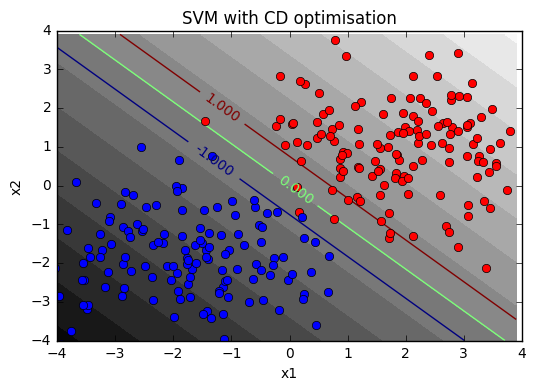

In [28]:
def cd(model, mu_init, C, n_iter=100, callback=None):         
    mu = mu_init.copy()
    
    Li = np.array([np.sqrt(np.dot(model.GGT[:, i], model.GGT[:, i])) for i in range(model.GGT.shape[1])])
    step = 1./Li
        
    for k in range(n_iter + 1):
        i = k % n_points
        
        mu[i] = model.prox(mu[i] - (step[i] * (model.GGT[:, i].T.dot(mu) - 1)), C) # Smart update, not using the full gradient here
        
        if callback: 
            callback(mu)
        
    idx_support = np.where(np.abs(mu) > 1e-5)[0]
    mu_support = mu[idx_support]
        
    return mu_support, idx_support

mu_init = np.zeros(n_points)
n_iter = 200

print('CD convergence checking:')
cd_inspector = inspector(model.loss, n_iter=n_points*n_iter, verbose=True) # The numerical cost is divided by n_points on average
mu_support, idx_support = cd(model, mu_init, C=1., n_iter=n_points*n_iter, callback=cd_inspector)

b = 0
plt.title('SVM with CD optimisation')
plot_classif(X_old, y, mu_support, idx_support, b, kernel = kernel)

L-BFGS-B convergence checking:
   it    |   obj    |   err   
       0 | 6.13e+00 | 2.78e+00
      40 | 1.79e-01 | 6.82e-01
      80 | 9.77e-03 | 1.76e-01


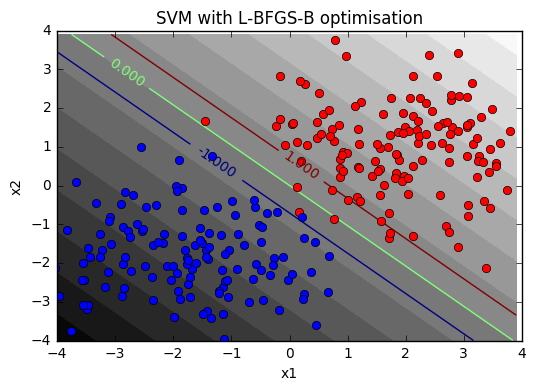

In [29]:
def l_bfgs_b(model, mu_init, C, callback=None):    
    
    bounds = [(0, C)] * n_points
            
    mu, _, _ = fmin_l_bfgs_b(model.loss, mu_init, model.grad, bounds=bounds, callback=callback)

    idx_support = np.where(np.abs(mu) > 1e-5)[0]
    mu_support = mu[idx_support]
        
    return mu_support, idx_support

mu_init = np.zeros(n_points)
n_iter = 200

print('L-BFGS-B convergence checking:')
bfgs_inspector = inspector(model.loss, n_iter=n_iter, verbose=True)
mu_support, idx_support = l_bfgs_b(model, mu_init, C=1., callback=bfgs_inspector)

b = 0
plt.title('SVM with L-BFGS-B optimisation')
plot_classif(X_old, y, mu_support, idx_support, b, kernel = kernel)